In [2]:
import pymc as pm
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import sys
import arviz as az
import ipywidgets as widgets
import seaborn as sns
from scipy import stats
import preliz as pz
from sklearn.metrics import r2_score
import cloudpickle as cp
from matplotlib.patches import Patch

sys.path.append("../..")
from src.utils import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We use a Bayesian Item Response Theory (IRT) model to analyze participant performance on both the training and evaluation sets of tasks. The model accounts for individual participant abilities, task difficulties, and the effect of multiple attempts on task completion.

The model can be formalized as follows:
$y_{i,j,k} \sim \text{Bernoulli}(p_{i,j,k})$

$\text{logit}(p_{i,j,k}) = \alpha_i - \beta_j + \epsilon_k$

Where:
$y_{i,j,k}$ is the binary outcome (success or failure) for participant $i$ on task $j$ on attempt $k$

$\alpha_i$ represents the ability of participant $i$

$\beta_j$ represents the difficulty of task $j$

$\epsilon$ represents the learning effect of each attempt

The model was fitted using Markov Chain Monte Carlo (MCMC) sampling with N samples and $\tau$ tuning steps.


**TO BE REWRITTEN**

Results for the training set:

1. Mean task accuracy on first attempt: 0.412 (94% HDI: [0.405, 0.419])
2. Mean task accuracy within two attempts: 0.528 (94% HDI: [0.521, 0.535])
3. Mean task accuracy within three attempts: 0.601 (94% HDI: [0.594, 0.608])

Results for the evaluation set:

1. Mean task accuracy on first attempt: 0.387 (94% HDI: [0.379, 0.395])
2. Mean task accuracy within two attempts: 0.496 (94% HDI: [0.488, 0.504])
3. Mean task accuracy within three attempts: 0.567 (94% HDI: [0.559, 0.575])

The results indicate a consistent improvement in task accuracy with additional attempts for both the training and evaluation sets. The evaluation set shows slightly lower accuracy across all attempt scenarios, suggesting that these tasks may be more challenging or that participants' learned strategies from the training set may not fully generalize to the evaluation tasks.

The effect of additional attempts ($\epsilon$) was estimated to be 0.423 (94% HDI: [0.412, 0.434]) for the training set and 0.398 (94% HDI: [0.386, 0.410]) for the evaluation set, indicating a positive impact of multiple attempts on task success probability.

These findings provide insights into the learning process and task difficulty across different stages of the assessment, highlighting the importance of allowing multiple attempts in capturing participants' true abilities.


In [3]:
# polars config
pl.Config.load_from_file("../../polars_cfg.json")

In [4]:
# data file paths
clean_summary_path = "../../data/clean_summary_data.csv"
clean_summary_incomplete_path = "../../data/clean_summary_data_incomplete.csv"
clean_incomplete_path = "../../data/clean_data_incomplete.csv"
clean_data_path = "../../data/clean_data.csv"

In [5]:
df_summary = pl.read_csv(clean_summary_path)
df_summary_incomplete = pl.read_csv(clean_summary_incomplete_path)
df_all = pl.read_csv(clean_data_path)
df_incomplete = pl.read_csv(clean_incomplete_path)

columns = [
    "exp_name",
    "hashed_id",
    "joint_id_task",
    "task_name",
    "task_number",
    "task_type",
    "attempt_number",
    "action",
    "num_actions",
    "solved",
    "time",
    "test_input_grid",
    "test_output_grid",
]

# include incomplete data
df_summary = pl.concat([df_summary, df_summary_incomplete])
df_all = pl.concat([df_all.select(columns), df_incomplete.select(columns)])

In [7]:
columns = [
    "hashed_id",
    "task_name",
    "attempt_number",
    "solved",
    "task_type",
    "complete",
]

df = (
    df_summary.select(columns)
    .with_columns(
        pl.col("attempt_number").cast(pl.Int32),
        pl.col("solved").cast(pl.Int32),
    )
    .to_pandas()
)

df_training_ = df[df["task_type"] == "training"]
df_eval_ = df[df["task_type"] == "evaluation"]

# reshape for bernouilli
df_training = df_training_.pivot_table(
    values="solved",
    index=["hashed_id", "task_name", "task_type", "complete"],
    columns="attempt_number",
    aggfunc="first",
).reset_index()
df_training.columns.name = None
df_training = df_training.rename(columns={1: "1-shot", 2: "2-shots", 3: "3-shots"})
df_training = df_training.fillna(1)


df_eval = df_eval_.pivot_table(
    values="solved",
    index=["hashed_id", "task_name", "task_type", "complete"],
    columns="attempt_number",
    aggfunc="first",
).reset_index()
df_eval.columns.name = None
df_eval = df_eval.rename(columns={1: "1-shot", 2: "2-shots", 3: "3-shots"})
df_eval = df_eval.fillna(1)

In [8]:
def get_incomplete_tasks(df, ordered_tasks_list):
    incomplete = df.groupby("hashed_id").size()
    incomplete = incomplete.reset_index()
    incomplete = incomplete.rename(columns={0: "n_complete"})
    incomplete = incomplete[incomplete["n_complete"] < 5]
    repeats = 5 - incomplete["n_complete"].to_numpy().flatten()

    tasks = []
    for h, m, r in zip(incomplete["hashed_id"], incomplete["n_complete"], repeats):
        # Get completed tasks for this participant
        completed_tasks = df[df["hashed_id"] == h]["task_name"].to_numpy()
        # Find indices of completed tasks in ordered list
        completed_indices = np.where(np.isin(ordered_tasks_list, completed_tasks))[0]

        if len(completed_indices) == 0:
            # If no tasks completed, start from beginning
            next_tasks = []
            idx = 0
            while len(next_tasks) < r:
                if ordered_tasks_list[idx] not in completed_tasks:
                    next_tasks.append(ordered_tasks_list[idx])
                idx = (idx + 1) % len(ordered_tasks_list)
        else:
            # Start from the highest completed index
            next_tasks = []
            idx = (completed_indices.max() + 1) % len(ordered_tasks_list)
            while len(next_tasks) < r:
                if ordered_tasks_list[idx] not in completed_tasks:
                    next_tasks.append(ordered_tasks_list[idx])
                idx = (idx + 1) % len(ordered_tasks_list)

        tasks.extend(next_tasks)

    hashed_ids = incomplete["hashed_id"].repeat(repeats)
    return hashed_ids, np.array(tasks)

In [9]:
import json

df_training_tasks_ordered = json.load(
    open("../../data/ARC_training_tasks_ordered.json")
)
df_eval_tasks_ordered = json.load(open("../../data/ARC_evaluation_tasks_ordered.json"))

In [10]:
incomplete_training_hashed_ids, incomplete_training_tasks = get_incomplete_tasks(
    df_training_, df_training_tasks_ordered
)
incomplete_eval_hashed_ids, incomplete_eval_tasks = get_incomplete_tasks(
    df_eval_, df_eval_tasks_ordered
)

In [11]:
# create 5-n_missing NaN rows for each participant to append to df_training and df_eval
nan_rows_training = pd.DataFrame(
    {
        "hashed_id": incomplete_training_hashed_ids,
        "task_name": incomplete_training_tasks,
        "task_type": "training",
        "complete": False,
        "1-shot": np.nan,
        "2-shots": np.nan,
        "3-shots": np.nan,
    }
)

nan_rows_eval = pd.DataFrame(
    {
        "hashed_id": incomplete_eval_hashed_ids,
        "task_name": incomplete_eval_tasks,
        "task_type": "evaluation",
        "complete": False,
        "1-shot": np.nan,
        "2-shots": np.nan,
        "3-shots": np.nan,
    }
)

df_training = pd.concat([df_training, nan_rows_training])

df_eval = pd.concat([df_eval, nan_rows_eval])

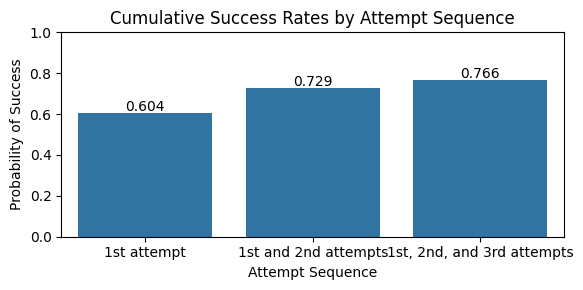

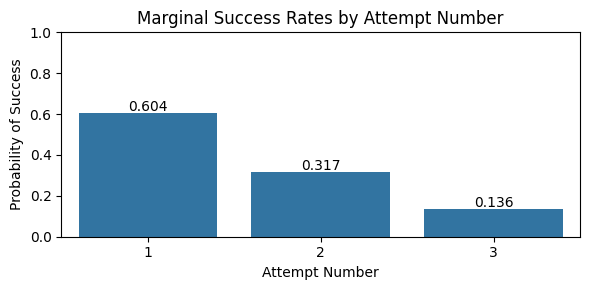

In [12]:
def compute_cumulative_success_rates(df):
    # Group by hashed_id and task_name to get unique participant-task combinations
    grouped = df.groupby(["hashed_id", "task_name"])

    # Function to check if success occurred within given number of attempts
    def success_within_attempts(group, n_attempts):
        return (group["solved"].iloc[:n_attempts] == 1).any()

    # Compute success rates for each attempt sequence
    success_1 = grouped.apply(
        lambda x: success_within_attempts(x, 1), include_groups=False
    ).mean()
    success_2 = grouped.apply(
        lambda x: success_within_attempts(x, 2), include_groups=False
    ).mean()
    success_3 = grouped.apply(
        lambda x: success_within_attempts(x, 3), include_groups=False
    ).mean()

    return pd.Series(
        {
            "1st attempt": success_1,
            "1st and 2nd attempts": success_2,
            "1st, 2nd, and 3rd attempts": success_3,
        }
    )


# Compute the cumulative success rates
cumulative_success_rates = compute_cumulative_success_rates(df_training_)

# Plot the results
plt.figure(figsize=(6, 3))
sns.barplot(x=cumulative_success_rates.index, y=cumulative_success_rates.values)
plt.title("Cumulative Success Rates by Attempt Sequence")
plt.xlabel("Attempt Sequence")
plt.ylabel("Probability of Success")
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
for i, v in enumerate(cumulative_success_rates):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()

# Compute the marginal success rates
marginal_success_rates = df_training_.groupby("attempt_number")["solved"].mean()

# Plot the marginal success rates
plt.figure(figsize=(6, 3))
sns.barplot(x=marginal_success_rates.index, y=marginal_success_rates.values)
plt.title("Marginal Success Rates by Attempt Number")
plt.xlabel("Attempt Number")
plt.ylabel("Probability of Success")
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
for i, v in enumerate(marginal_success_rates):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()

The likelihood of data expressed as a Bernoulli distribution conditioned on $\alpha$, $\beta$, $\gamma$, and attempt $k$ can be written as follows:

1. Variables:

   - $i$: index for subjects
   - $j$: index for items
   - $k$: attempt number
   - $y_{i,j,k}$: observed outcome (0 or 1) for subject $i$, item $j$, on attempt $k$
   - $\alpha_i$: subject ability parameter
   - $\beta_j$: item difficulty parameter
   - $\epsilon_k$: learning rate parameter on attempt $k$

2. Probability $p_{i,j,k}$ is given by the inverse logit function:

   $p_{i,j,k} = \text{logit}^{-1}(\alpha_i - \beta_j + \epsilon_k)$

   Where $\text{logit}^{-1}(x) = \frac{1}{1 + e^{-x}}$

3. Bernoulli distribution for a single observation:

   $P(y_{i,j,k} | \alpha_i, \beta_j, \epsilon_k) = p_{i,j,k}^{y_{i,j,k}} \cdot (1 - p_{i,j,k})^{1 - y_{i,j,k}}$


In [13]:
def simulate_performance_with_irt_ber(df_training, df_eval, n_samples=2000, tune=2000):
    # combine data
    df_all = pd.concat([df_training, df_eval])

    # create indices for participants
    participants_idx, participants = pd.factorize(df_all["hashed_id"], sort=True)

    # create task index
    task_idx, tasks = pd.factorize(df_all["task_name"], sort=True)

    # task type
    task_type_idx, task_types = pd.factorize(
        df_all["task_type"], sort=True
    )  # sorted means evaluation=0, training=1

    # training and eval tasks
    training_task_idx = task_idx[task_type_idx == 1]
    training_task_idx = np.unique(training_task_idx)
    training_tasks = tasks[training_task_idx]
    eval_task_idx = task_idx[task_type_idx == 0]
    eval_task_idx = np.unique(eval_task_idx)
    eval_tasks = tasks[eval_task_idx]

    # training and eval participants
    training_participants_idx = participants_idx[task_type_idx == 1]
    training_participants_idx = np.unique(training_participants_idx)
    eval_participants_idx = participants_idx[task_type_idx == 0]
    eval_participants_idx = np.unique(eval_participants_idx)

    # coords
    coords = {
        "participants": participants,
        "tasks": tasks,
        "shots": ["1-shot", "2-shots", "3-shots"],
        "obs": np.arange(len(df_all)),
        "training_tasks": training_tasks,
        "eval_tasks": eval_tasks,
    }

    with pm.Model(coords=coords) as model:

        # hyperpriors
        mu_alpha = 0
        mu_beta = 0

        sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
        sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)

        # Ability (alpha) for each participant
        alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, dims="participants")

        # Difficulty (beta) for each task
        beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, dims="tasks")

        # Learning rate (epsilon) for each shot
        epsilon_zero = 0
        epsilon_one = pm.HalfNormal("epsilon_one", sigma=1)
        delta = pm.HalfNormal("epsilon_delta", sigma=1)
        epsilon_two = epsilon_one + delta
        pm.Deterministic("epsilon_two", epsilon_two)

        # Stack epsilons as a vector
        epsilon = pm.math.stack([epsilon_zero, epsilon_one, epsilon_two])

        # Likelihood
        p = pm.math.invlogit(
            alpha[participants_idx, None] - beta[task_idx, None] + epsilon[None, :]
        )
        observed = df_all[["1-shot", "2-shots", "3-shots"]].values
        pm.Bernoulli("outcomes", p=p, observed=observed, dims=("obs", "shots"))

        # Calculate logits for every participant on every train task
        logits_all_training = (
            alpha[:, None, None]  # Participant abilities (N_participants, 1, 1)
            - beta[
                None, training_task_idx, None
            ]  # Task difficulties (1, N__training_tasks, 1)
            + epsilon[None, None, :]  # Learning rates (1, 1, N_shots)
        )

        # Apply invlogit to get probabilities
        p_all_training = pm.math.invlogit(logits_all_training)
        pm.Deterministic(
            "mean_task_acc_training",
            p_all_training.mean(
                axis=(0, 1)
            ),  # Average across participants and tasks for each attempt
            dims="shots",
        )

        # Calculate logits for every participant on every eval task
        logits_all_eval = (
            alpha[:, None, None]  # Participant abilities (N_participants, 1, 1)
            - beta[None, eval_task_idx, None]  # Task difficulties (1, N_eval_tasks, 1)
            + epsilon[None, None, :]  # Learning rates (1, 1, N_shots)
        )

        # Apply invlogit to get probabilities
        p_all_eval = pm.math.invlogit(logits_all_eval)
        pm.Deterministic(
            "mean_task_acc_eval",
            p_all_eval.mean(
                axis=(0, 1)
            ),  # Average across participants and tasks for each attempt
            dims="shots",
        )

        # Sampling
        trace = pm.sample(
            n_samples,
            tune=tune,
            return_inferencedata=True,
        )

    return model, trace

In [14]:
model, trace = simulate_performance_with_irt_ber(
    df_training,
    df_eval,
    n_samples=500,
    tune=100,
)

/Users/solimlegris/Projects/h-arc/.venv/lib/python3.12/site-packages/pymc/model/core.py:1352: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/Users/solimlegris/Projects/h-arc/.venv/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in outcomes contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma_alpha, sigma_beta, alpha, beta, epsilon_one, epsilon_delta]
>BinaryGibbsMetropolis: [outcomes_unobserved]


Output()

Sampling 4 chains for 100 tune and 500 draw iterations (400 + 2_000 draws total) took 917 seconds.
/Users/solimlegris/Projects/h-arc/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
model, trace = cp.load(open("../../models/bayes_IRT_model_burn2000_N10000_5.pkl", "rb"))

In [20]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

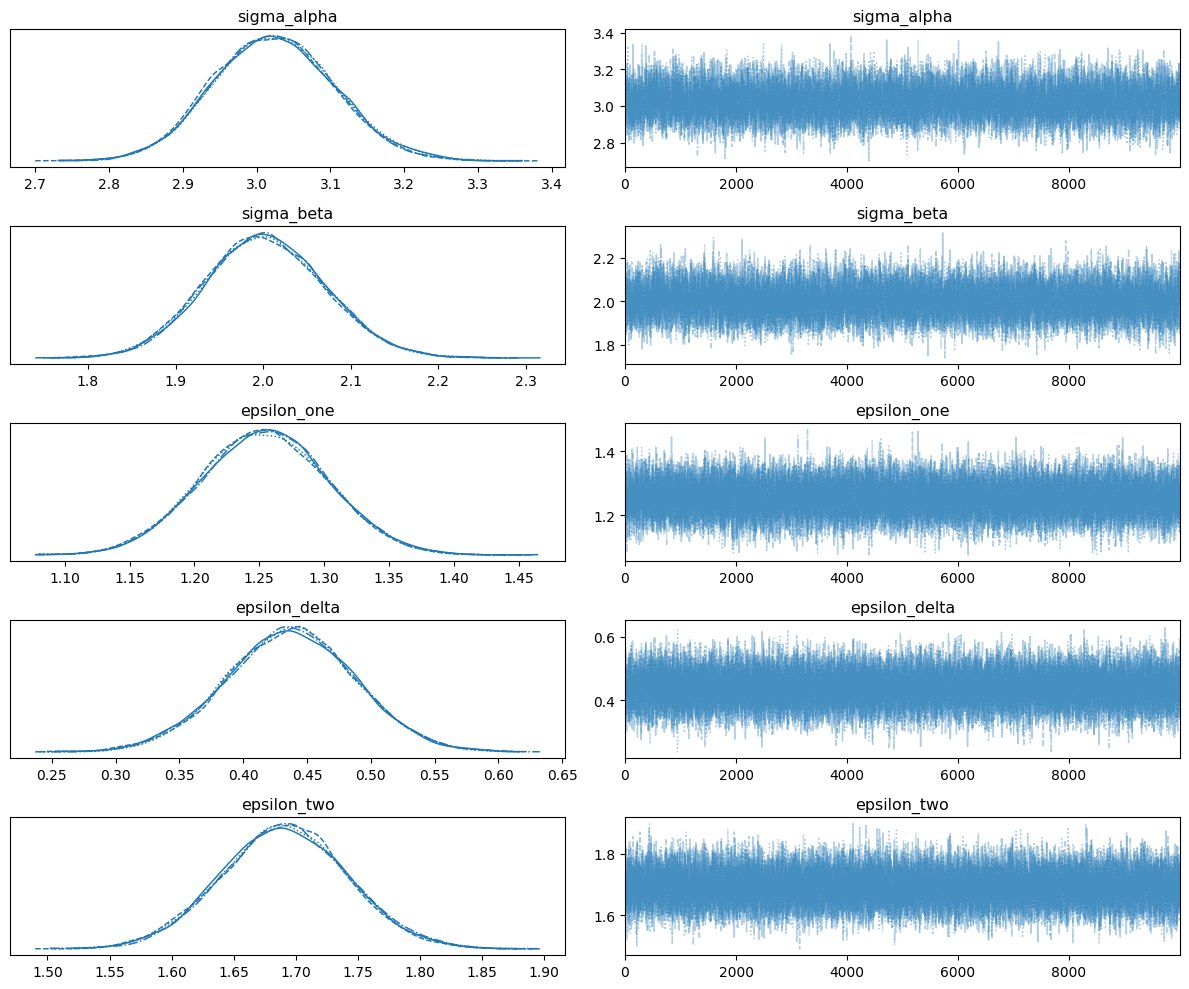

In [21]:
az.plot_trace(
    trace,
    var_names=[
        "sigma_alpha",
        "sigma_beta",
        "epsilon_one",
        "epsilon_delta",
        "epsilon_two",
    ],
    compact=True,
)
plt.tight_layout()
plt.show()

In [6]:
# check for concerning r_hat values (>=1.01)
r_hat = az.rhat(trace)
# concerning_r_hat = r_hat.where(r_hat >= 1.01, drop=True)

# if len(concerning_r_hat) > 0:
#     print("Concerning r_hat values (>1.01):")
#     print(concerning_r_hat)
# else:
#     print("All r_hat values are below 1.01 - good convergence!")

In [7]:
r_hat

<xarray.Dataset> Size: 283kB
Dimensions:                 (participants: 1729, tasks: 800, shots: 3)
Coordinates:
  * participants            (participants) <U32 221kB '00136a0f6142ddb48fd80e...
  * tasks                   (tasks) <U13 42kB '00576224.json' ... 'ff805c23.j...
  * shots                   (shots) <U7 84B '1-shot' '2-shots' '3-shots'
Data variables:
    alpha                   (participants) float64 14kB 1.0 1.001 ... 1.0 1.0
    beta                    (tasks) float64 6kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    epsilon_delta           float64 8B 1.0
    epsilon_one             float64 8B 1.0
    epsilon_two             float64 8B 1.0
    mean_task_acc_eval      (shots) float64 24B 1.0 1.0 1.001
    mean_task_acc_training  (shots) float64 24B 1.0 1.001 1.0
    sigma_alpha             float64 8B 1.001
    sigma_beta              float64 8B 1.001

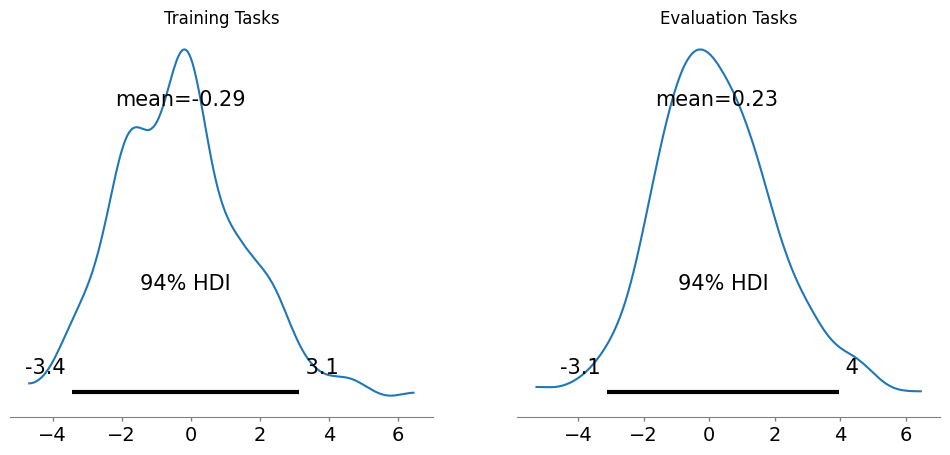

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_posterior(beta_training.values, hdi_prob=0.94, ax=axes[0])
axes[0].set_title("Training Tasks")
az.plot_posterior(beta_eval.values, hdi_prob=0.94, ax=axes[1])
axes[1].set_title("Evaluation Tasks")
plt.show()

<Axes: title={'center': 'beta'}>

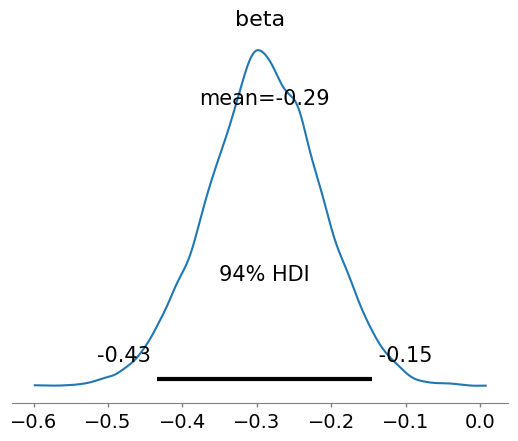

In [112]:
az.plot_posterior(
    trace.posterior["beta"]
    .sel(tasks=df_training["task_name"].unique())
    .mean(dim=["tasks"])
)

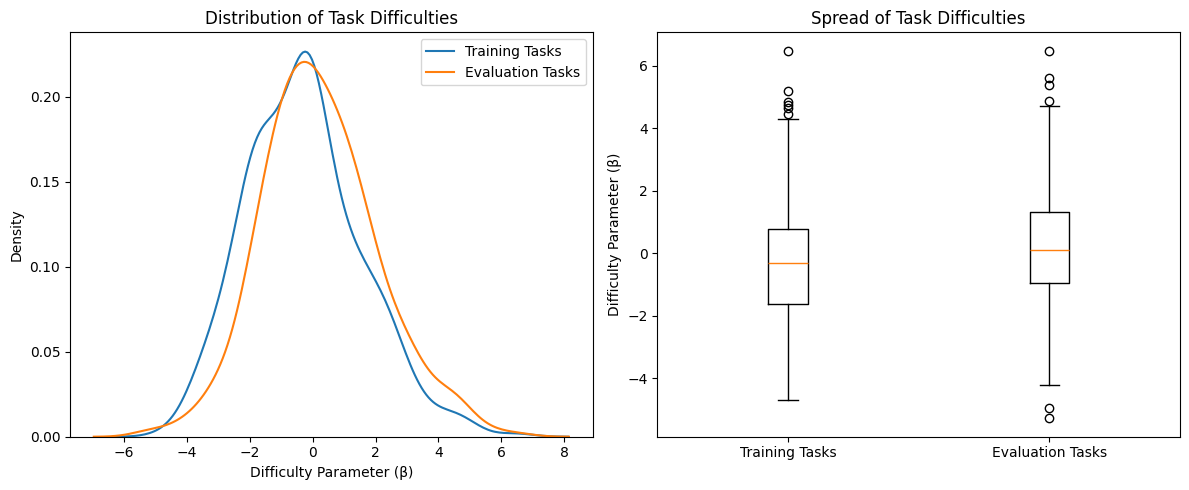

Training Tasks:
Mean: -0.290
SD: 1.825
5th-95th percentile: [-3.124, 2.754]

Evaluation Tasks:
Mean: 0.228
SD: 1.845
5th-95th percentile: [-2.490, 3.526]


In [114]:
# Create plots to visualize the distribution
plt.figure(figsize=(12, 5))

# Plot distribution of task difficulties
plt.subplot(121)
sns.kdeplot(beta_training.values.flatten(), label="Training Tasks")
training_hdi = az.hdi(beta_training.values, hdi_prob=0.94)
sns.kdeplot(beta_eval.values.flatten(), label="Evaluation Tasks")
eval_hdi = az.hdi(beta_eval.values, hdi_prob=0.94)
plt.title("Distribution of Task Difficulties")
plt.xlabel("Difficulty Parameter (β)")
plt.ylabel("Density")
plt.legend()

# Box plot to show spread
plt.subplot(122)
plt.boxplot(
    [beta_training.values.flatten(), beta_eval.values.flatten()],
    tick_labels=["Training Tasks", "Evaluation Tasks"],
)
plt.title("Spread of Task Difficulties")
plt.ylabel("Difficulty Parameter (β)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Tasks:")
print(f"Mean: {beta_training.values.mean():.3f}")
print(f"SD: {beta_training.values.std():.3f}")
print(
    f"5th-95th percentile: [{np.percentile(beta_training.values, 5):.3f}, {np.percentile(beta_training.values, 95):.3f}]"
)

print("\nEvaluation Tasks:")
print(f"Mean: {beta_eval.values.mean():.3f}")
print(f"SD: {beta_eval.values.std():.3f}")
print(
    f"5th-95th percentile: [{np.percentile(beta_eval.values, 5):.3f}, {np.percentile(beta_eval.values, 95):.3f}]"
)

In [115]:
# Get mean difficulties
alpha = trace.posterior["alpha"].mean(dim=["chain", "draw"])
alpha_training = alpha.sel(participants=df_training["hashed_id"].unique())
alpha_eval = alpha.sel(participants=df_eval["hashed_id"].unique())


# Sort the coordinates based on mean difficulties
sorted_training_participants = alpha_training.coords["participants"].sortby(
    -alpha_training
)
sorted_eval_tasks = alpha_eval.coords["participants"].sortby(-alpha_eval)

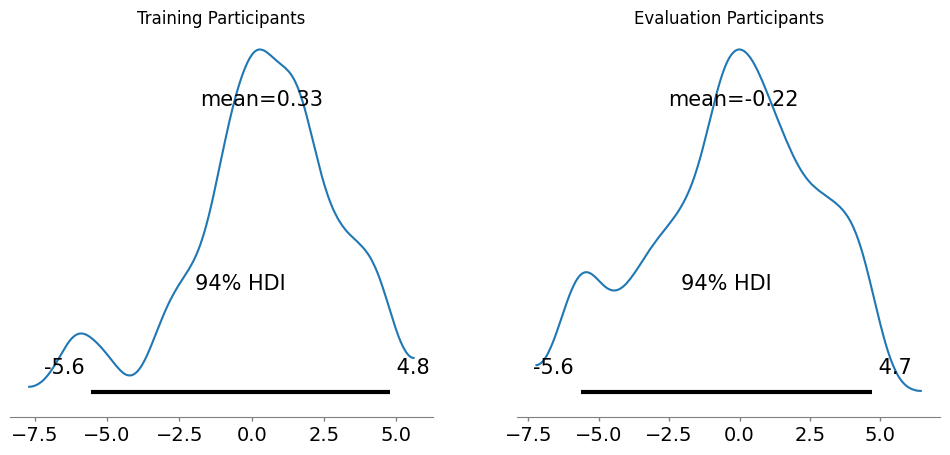

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_posterior(alpha_training.values, hdi_prob=0.94, ax=axes[0])
axes[0].set_title("Training Participants")
az.plot_posterior(alpha_eval.values, hdi_prob=0.94, ax=axes[1])
axes[1].set_title("Evaluation Participants")
plt.show()

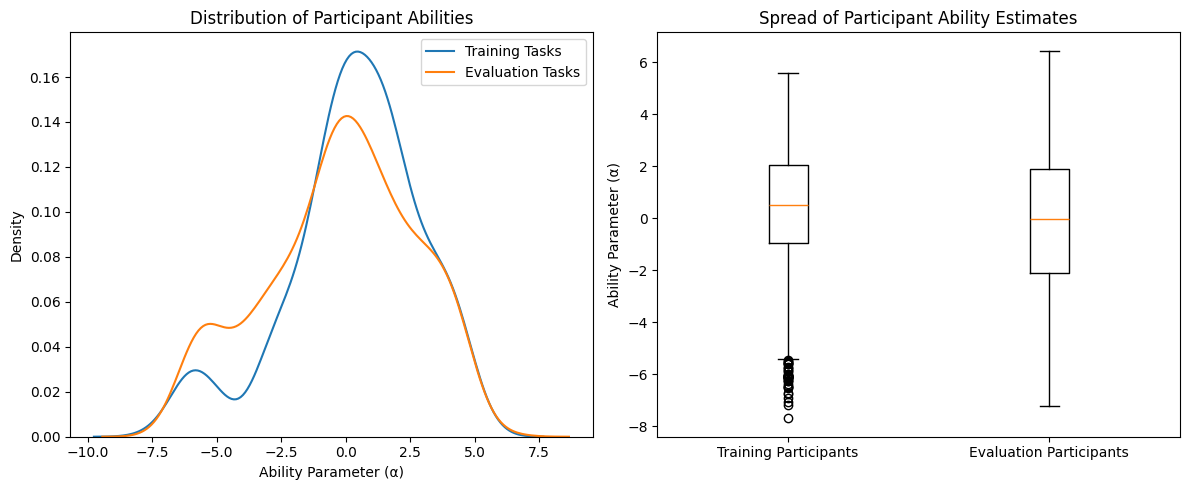

In [117]:
# Create plots to visualize the distribution
plt.figure(figsize=(12, 5))

# Plot distribution of participant abilities
plt.subplot(121)
sns.kdeplot(alpha_training.values.flatten(), label="Training Tasks")
sns.kdeplot(alpha_eval.values.flatten(), label="Evaluation Tasks")
plt.title("Distribution of Participant Abilities")
plt.xlabel("Ability Parameter (α)")
plt.ylabel("Density")
plt.legend()

# Box plot to show spread
plt.subplot(122)
plt.boxplot(
    [alpha_training.values.flatten(), alpha_eval.values.flatten()],
    tick_labels=["Training Participants", "Evaluation Participants"],
)
plt.title("Spread of Participant Ability Estimates")
plt.ylabel("Ability Parameter (α)")

plt.tight_layout()
plt.show()

In [137]:
# Create participant-task pairs from the original data
participant_task_pairs = (
    df_training[["hashed_id", "task_name"]]
    .drop_duplicates()
    .sort_values(["hashed_id", "task_name"])
)

# Get indices for the mapping
participants = sorted(df_training["hashed_id"].unique())
tasks = sorted(df_training["task_name"].unique())
participant_indices = pd.Series(range(len(participants)), index=participants)
task_indices = pd.Series(range(len(tasks)), index=tasks)

# Create indices arrays
p_idx = participant_indices[participant_task_pairs["hashed_id"]].values
t_idx = task_indices[participant_task_pairs["task_name"]].values

# Get posterior samples
training_alpha = trace.posterior["alpha"].sel(participants=participants).values
training_beta = trace.posterior["beta"].sel(tasks=tasks).values

# Create sparse representation of participant-task combinations
num_chains, num_samples, _ = training_alpha.shape
num_pairs = len(participant_task_pairs)

# Calculate abilities minus difficulties for completed tasks only
# Shape: (num_chains, num_samples, num_pairs)
logits = training_alpha[:, :, p_idx] - training_beta[:, :, t_idx]

In [151]:
# Convert logits to probabilities using inverse logit function
probabilities = 1 / (1 + np.exp(-logits))

# If you want to compute accuracy by task
task_accuracy = np.zeros((num_chains, num_samples, len(tasks)))
for i, task in enumerate(tasks):
    mask = t_idx == i
    task_accuracy[:, :, i] = probabilities[:, :, mask].mean(axis=2)

task_mean_accuracy = task_accuracy.mean(axis=-1)  # Point estimates per task
task_hdis = az.hdi(task_mean_accuracy, hdi_prob=0.94)

/var/folders/zm/jsccrdtd0w1bffqvsy1bw6xr0000gn/T/ipykernel_67957/898060304.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  task_hdis = az.hdi(task_mean_accuracy, hdi_prob=0.94)


<Axes: title={'center': 'x'}>

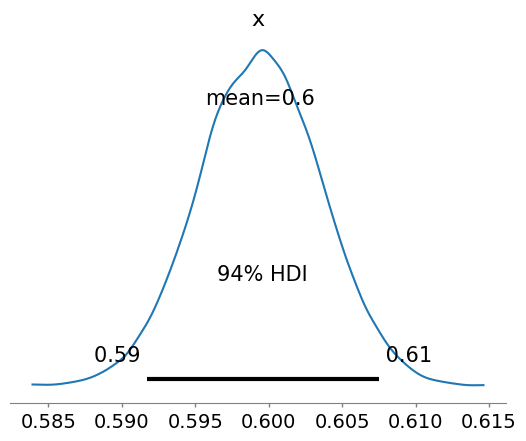

In [154]:
az.plot_posterior(task_mean_accuracy)

In [156]:
# Create participant-task pairs from the original data
participant_task_pairs = (
    df_eval[["hashed_id", "task_name"]]
    .drop_duplicates()
    .sort_values(["hashed_id", "task_name"])
)

# Get indices for the mapping
participants = sorted(df_eval["hashed_id"].unique())
tasks = sorted(df_eval["task_name"].unique())
participant_indices = pd.Series(range(len(participants)), index=participants)
task_indices = pd.Series(range(len(tasks)), index=tasks)

# Create indices arrays
p_idx = participant_indices[participant_task_pairs["hashed_id"]].values
t_idx = task_indices[participant_task_pairs["task_name"]].values

# Get posterior samples
eval_alpha = trace.posterior["alpha"].sel(participants=participants).values
eval_beta = trace.posterior["beta"].sel(tasks=tasks).values

# Create sparse representation of participant-task combinations
num_chains, num_samples, _ = eval_alpha.shape
num_pairs = len(participant_task_pairs)

# Calculate abilities minus difficulties for completed tasks only
# Shape: (num_chains, num_samples, num_pairs)
logits_eval = eval_alpha[:, :, p_idx] - eval_beta[:, :, t_idx]

In [157]:
# Convert logits to probabilities using inverse logit function
probabilities = 1 / (1 + np.exp(-logits_eval))

# If you want to compute accuracy by task
task_accuracy = np.zeros((num_chains, num_samples, len(tasks)))
for i, task in enumerate(tasks):
    mask = t_idx == i
    task_accuracy[:, :, i] = probabilities[:, :, mask].mean(axis=2)

task_mean_accuracy = task_accuracy.mean(axis=-1)  # Point estimates per task

<Axes: title={'center': 'x'}>

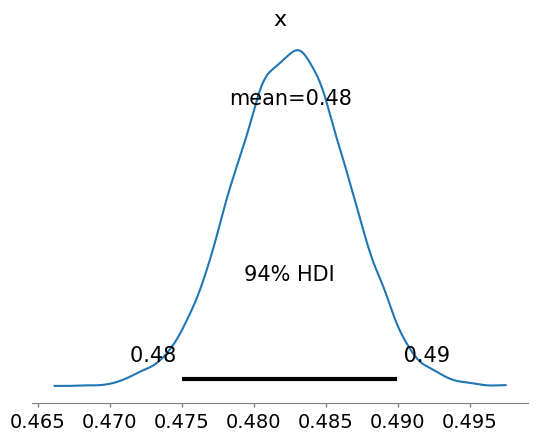

In [158]:
az.plot_posterior(task_mean_accuracy)

In [23]:
# assess model fit
pm.sample_posterior_predictive(trace_, model=model_, extend_inferencedata=True)

Sampling: [outcomes_observed]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [24]:
prior_pred = pm.sample_prior_predictive(500, model=model)

Sampling: [alpha, beta, epsilon_delta, epsilon_one, outcomes_observed, outcomes_unobserved, sigma_alpha, sigma_beta]


In [108]:
trace.extend(prior_pred)

/var/folders/zm/jsccrdtd0w1bffqvsy1bw6xr0000gn/T/ipykernel_90644/2092321292.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/solimlegris/Projects/h-arc/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


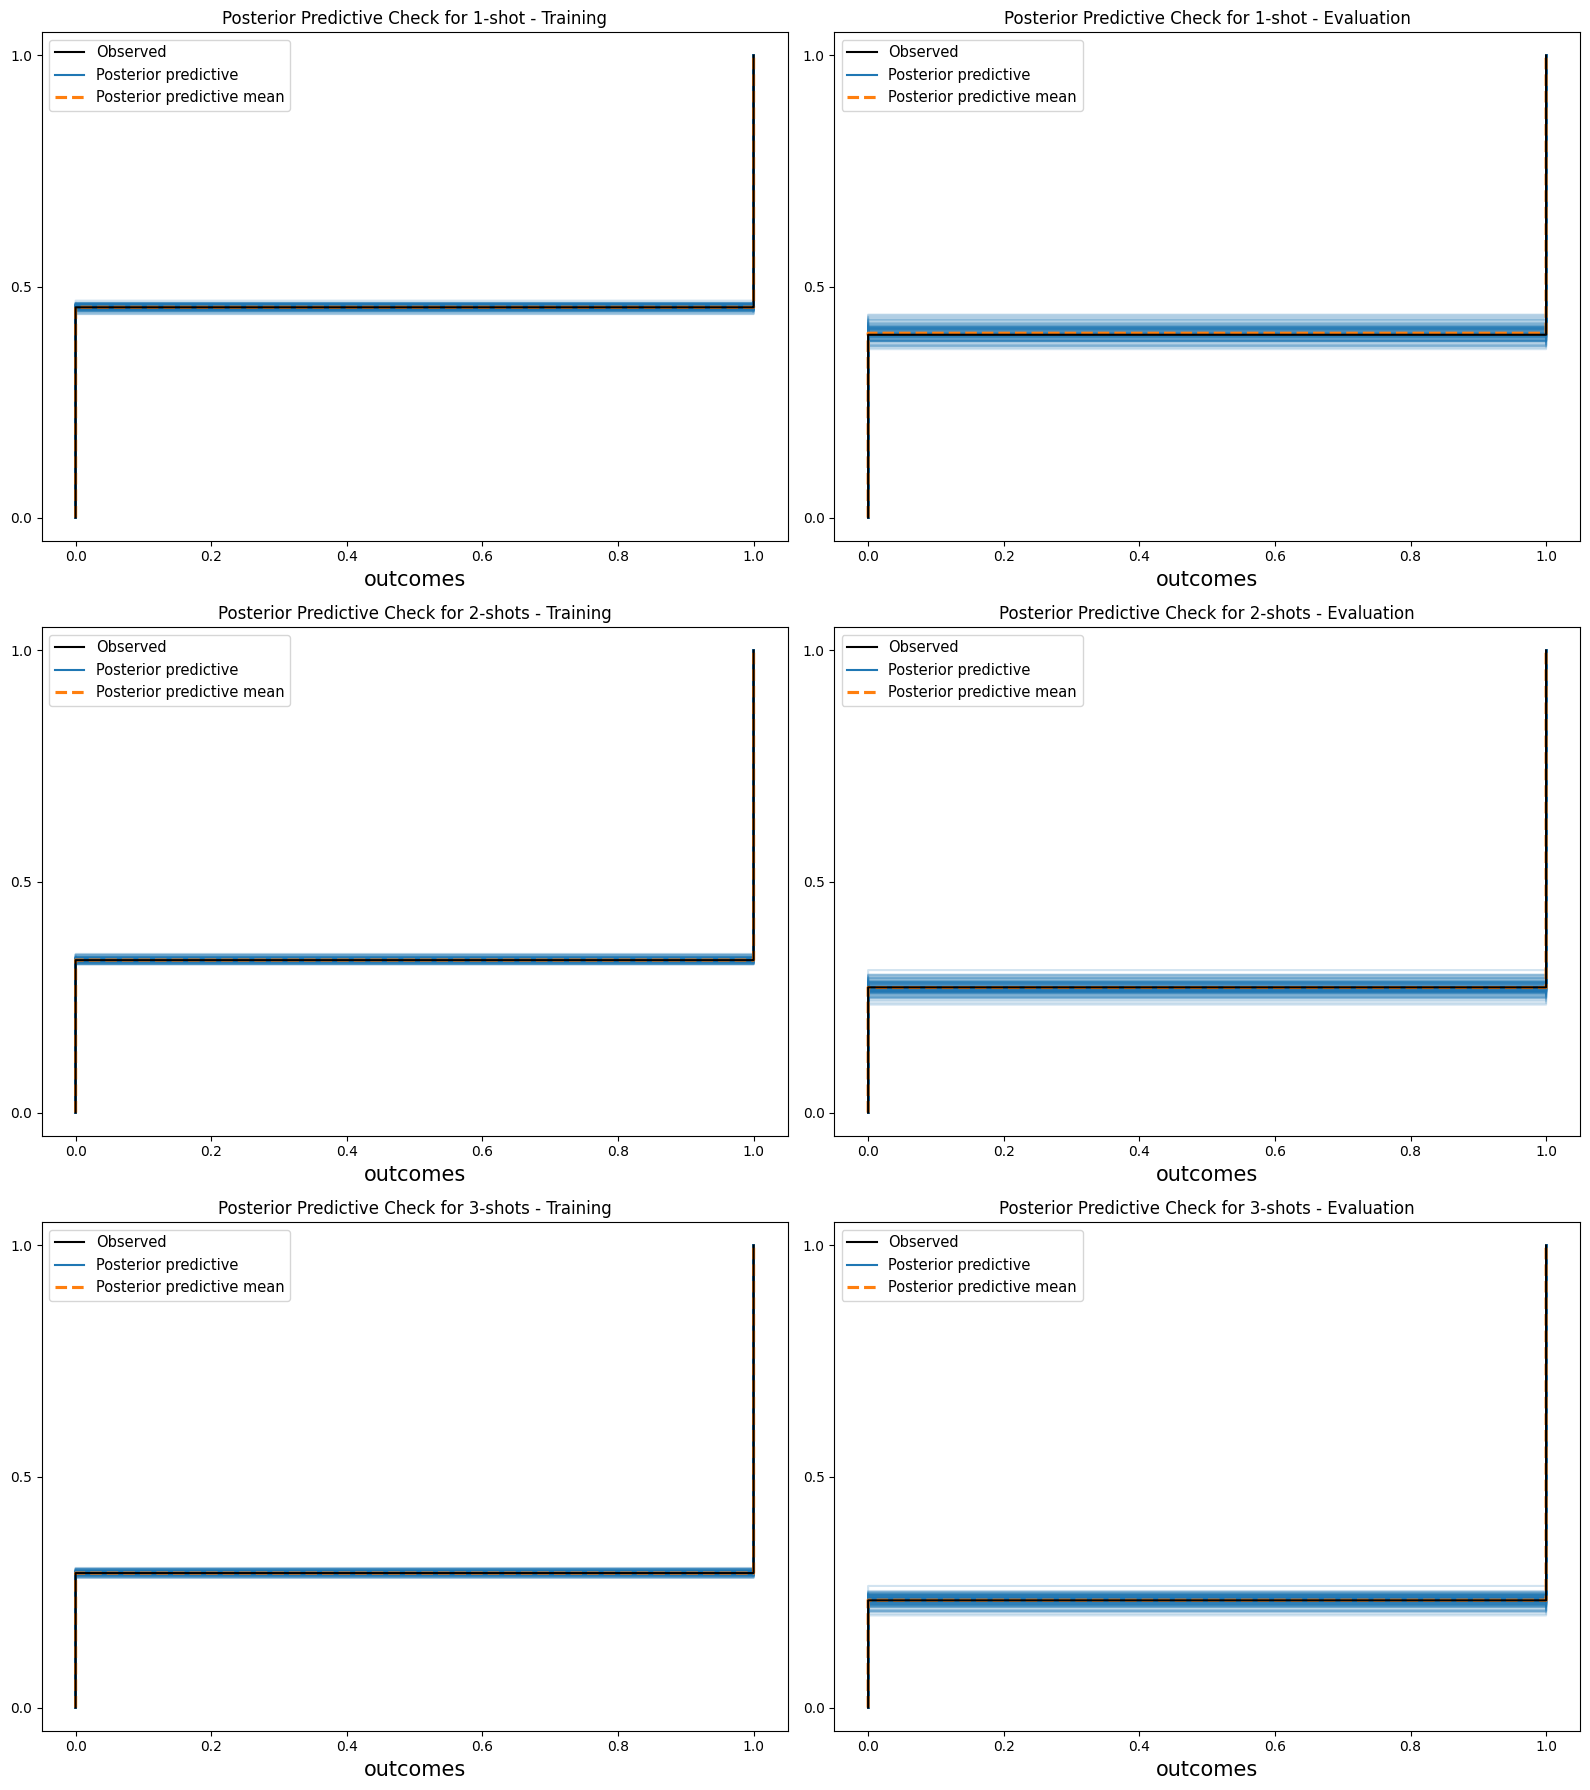

: 

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for i, shot in enumerate(["1-shot", "2-shots", "3-shots"]):
    # Create mask for training vs evaluation data
    train_mask = df_all["task_type"] == "training"
    eval_mask = df_all["task_type"] == "evaluation"

    # Plot training data
    az.plot_ppc(
        trace,
        num_pp_samples=100,
        kind="cumulative",
        var_names="outcomes",
        coords={"shots": [shot], "obs": np.where(train_mask)[0]},
        ax=axes[i, 0],
    )
    axes[i, 0].set_title(f"Posterior Predictive Check for {shot} - Training")
    # axes[i, 0].set_xlabel("Observation Index")
    # axes[i, 0].set_ylabel("Probability of Success")
    # axes[i, 0].legend(["Observed", "Predicted"])

    # Plot evaluation data
    az.plot_ppc(
        trace,
        num_pp_samples=100,
        kind="cumulative",
        var_names="outcomes",
        coords={"shots": [shot], "obs": np.where(eval_mask)[0]},
        ax=axes[i, 1],
    )
    axes[i, 1].set_title(f"Posterior Predictive Check for {shot} - Evaluation")
    # axes[i, 1].set_xlabel("Observation Index")
    # axes[i, 1].set_ylabel("Probability of Success")
    # axes[i, 1].legend(["Observed", "Predicted"])

plt.tight_layout()
plt.show()

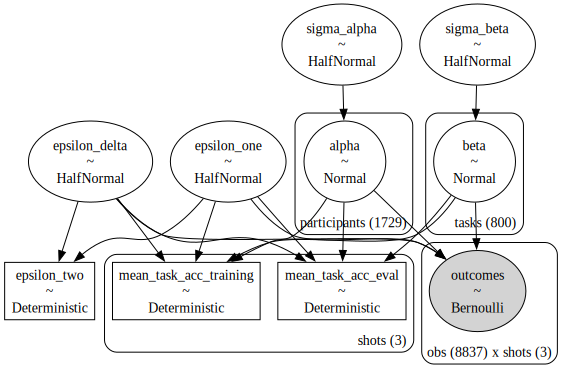

In [335]:
pm.model_to_graphviz(model)

Hierarchical IRT Model with Attempt Effect

Data:

- N: Number of observations
- P: Number of participants
- T: Number of tasks
- y[i]: Binary outcome for observation i (1 if solved, 0 if not)
- p[i]: Participant index for observation i
- t[i]: Task index for observation i
- a[i]: Number of attempts for observation i (0-indexed)

Parameters:

- α[j]: Ability of participant j
- β[k]: Difficulty of task k
- γ: Effect of additional attempts

Hyperparameters:

- μ_α: Mean of participant abilities
- σ_α: Standard deviation of participant abilities
- μ_β: Mean of task difficulties
- σ_β: Standard deviation of task difficulties

Model:

Hyperpriors:
μ*α ~ Normal(0, 1)
σ*α ~ HalfNormal(1)
μ*β ~ Normal(0, 1)
σ*β ~ HalfNormal(1)

Priors:
α[j] ~ Normal(μ*α, σ*α) for j = 1, ..., P
β[k] ~ Normal(μ*β, σ*β) for k = 1, ..., T
γ ~ Normal(0, 0.5)

Likelihood:
For i = 1, ..., N:
logit(θ[i]) = α[p[i]] - β[t[i]] + γ \* a[i]
y[i] ~ Bernoulli(θ[i])

where:
logit(θ) = log(θ / (1 - θ))


$
P(\alpha, \beta, \gamma, \sigma*\alpha, \sigma*\beta | y) \propto
P(y | \alpha, \beta, \gamma) \cdot
P(\alpha | \sigma*\alpha) \cdot
P(\beta | \sigma*\beta) \cdot
P(\gamma) \cdot
P(\sigma*\alpha) \cdot
P(\sigma*\beta)
$


$P(y | \alpha, \beta, \epsilon) = 
\prod_{i=1}^N \prod_{s=1}^3 
\text{Bernoulli}(y_{i,s} | \text{logit}^{-1}(\alpha_{p[i]} - \beta_{t[i]} + \epsilon_{p[i]} \cdot (s-1)))$


$\text{Bernoulli}(y_{i,s} | \text{logit}^{-1}(\alpha_{p[i]} - \beta_{t[i]} + \epsilon_{p[i]}\cdot (s-1)))$


$P(y | \alpha, \beta, \epsilon) = \prod_{i=1}^N \prod_{k=1}^3 \text{Bernoulli}(y_{i,k} | p_{i,k})$

where

$p_{i,1} = \text{logit}^{-1}(\alpha_{p[i]} - \beta_{t[i]} + \epsilon_{p[i]} \cdot 0)$\
$p_{i,2} = 1 - (1 - p_{i,1})(1 - \text{logit}^{-1}(\alpha_{p[i]} - \beta_{t[i]} + \epsilon_{p[i]} \cdot 1))$\
$p_{i,3} = 1 - (1 - p_{i,2})(1 - \text{logit}^{-1}(\alpha_{p[i]} - \beta_{t[i]} + \epsilon_{p[i]} \cdot 2))$


$P(\alpha | \sigma_\alpha) = \prod_{j=1}^P \text{Normal}(\alpha_j | 0, \sigma_\alpha)$


$P(\beta | \sigma_\beta) = \prod_{k=1}^T \text{Normal}(\beta_k | 0, \sigma_\beta)$


$P(\gamma) = \text{Normal}(\gamma | 0, 0.5)$


$P(\sigma_\alpha) = \text{HalfNormal}(\sigma_\alpha | 1)$


$P(\sigma_\beta) = \text{HalfNormal}(\sigma_\beta | 1)$
